In [40]:
%matplotlib inline

import os
from typing import Union
import zarr

import gcsfs
import s3fs
import sunpy.map

import dask.array as da
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import sunpy.visualization.colormaps as cm

from astropy.time import Time
from sunpy.visualization import axis_labels_from_ctype, wcsaxes_compat

from matplotlib import animation
from IPython.display import HTML
import astropy.units as u
from astropy.coordinates import SkyCoord
import cv2
from skimage.filters import threshold_multiotsu
from skimage.measure import label, regionprops
from skimage import exposure
import itertools
#from scipy.ndimage import label
from skimage.measure import label, regionprops
from skimage.morphology import closing, opening, square, disk
from skimage.feature import graycomatrix, graycoprops
from skimage.color import label2rgb
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull
from sklearn.cluster import KMeans
from skimage.segmentation import find_boundaries
from kneed import KneeLocator
import random

from matplotlib.patches import Patch
from skimage.measure import find_contours
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap

from matplotlib import cm
from itertools import cycle


### Let's access the HMI data

In [2]:
AWS_ZARR_ROOT = (
    "s3://gov-nasa-hdrl-data1/contrib/fdl-sdoml/fdl-sdoml-v2/sdomlv2.zarr/"
)


def s3_connection(path_to_zarr: os.path) -> s3fs.S3Map:
    """
    Instantiate connection to aws for a given path `path_to_zarr`
    """
    return s3fs.S3Map(
        root=path_to_zarr,
        s3=s3fs.S3FileSystem(anon=True),
        # anonymous access requires no credentials
        check=False,
    )


def load_single_aws_zarr(
    path_to_zarr: os.path,
    cache_max_single_size: int = None,
) -> Union[zarr.Array, zarr.Group]:
    """
    load zarr from s3 using LRU cache
    """
    return zarr.open(
        zarr.LRUStoreCache(
            store=s3_connection(path_to_zarr),
            max_size=cache_max_single_size,
        ),
        mode="r",
    )

In [3]:
root2 = load_single_aws_zarr(
    path_to_zarr="s3://gov-nasa-hdrl-data1/contrib/fdl-sdoml/fdl-sdoml-v2/sdomlv2_hmi.zarr/",
)
HMI_data = root2["2012"]["Bz"] #we will study the 2012 data specifically

### Let's put together a dataset to study, we used 50 images over the course of 10 days

In [4]:
#we want 5 images from each day for 10 days

images_per_day = 144  # assuming every ten minutes one image
images_needed_per_day = 5  # we want 5 images per day
total_days = 10  # Total days
start_index = 16600  # starting index, just random


# generate 5 indices per day for 10 days
indices = []
for day in range(total_days):
    day_start = start_index + day * images_per_day
    day_indices = np.linspace(day_start, day_start + images_per_day - 1, images_needed_per_day, dtype=int)
    indices.extend(day_indices)

# extract images
images = [HMI_data[idx] for idx in indices]

### Now we define 3 functions that will be useful in the segmentation process

In [5]:
#normalisation function, get the magnetic field values between -1 and 1
def normalize_hmi(image):
    return 2 * (image - np.min(image)) / (np.max(image) - np.min(image)) - 1
#thresh function, applying multiple otsu
def apply_multi_otsu(norm_image):
    thresholds = threshold_multiotsu(norm_image, classes=3)  # for 3 classes, we need two thresholds
    #print(f"Multi-level Otsu thresholds: {thresholds}") #uncomment to print the found threshold values
    low_thresh, high_thresh = thresholds
    binary_multots = np.zeros_like(norm_image, dtype=np.uint8)
    binary_multots[(norm_image < low_thresh) | (norm_image > high_thresh)] = 1  #create our binary mask
    return binary_multots
#filter function
def apply_morph_filter(bin_image):
    kern = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9,9))
    kern2 = cv2.getStructuringElement(cv2.MORPH_RECT,(3,2))
    closed_image = cv2.morphologyEx(bin_image, cv2.MORPH_CLOSE,kern)
    opened_closed = cv2.morphologyEx(closed_image, cv2.MORPH_OPEN,kern2)
    return opened_closed


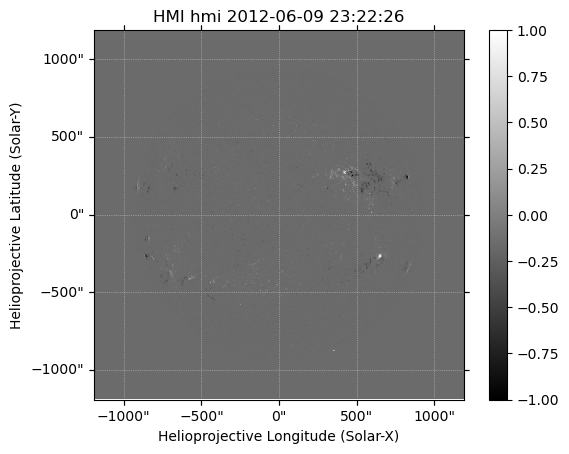

In [6]:
sunpy_maps = [] #keep a collection of sunpy maps (already normalized)
for i in indices:
    selected_headr = {keys: values[i] for keys, values in HMI_data.attrs.items()} 
    normalized_image = normalize_hmi(HMI_data[i])
    HMI_map = sunpy.map.Map(normalized_image, selected_headr)
    sunpy_maps.append(HMI_map)
sunpy_maps[30].peek()
#save the observation times, will be handy later
date_times = [sunpy_maps[j].meta["DATE-OBS"] for j in range(0,50)]



### Let's apply thresholding and morphological filtering to an image

<Figure size 640x480 with 0 Axes>

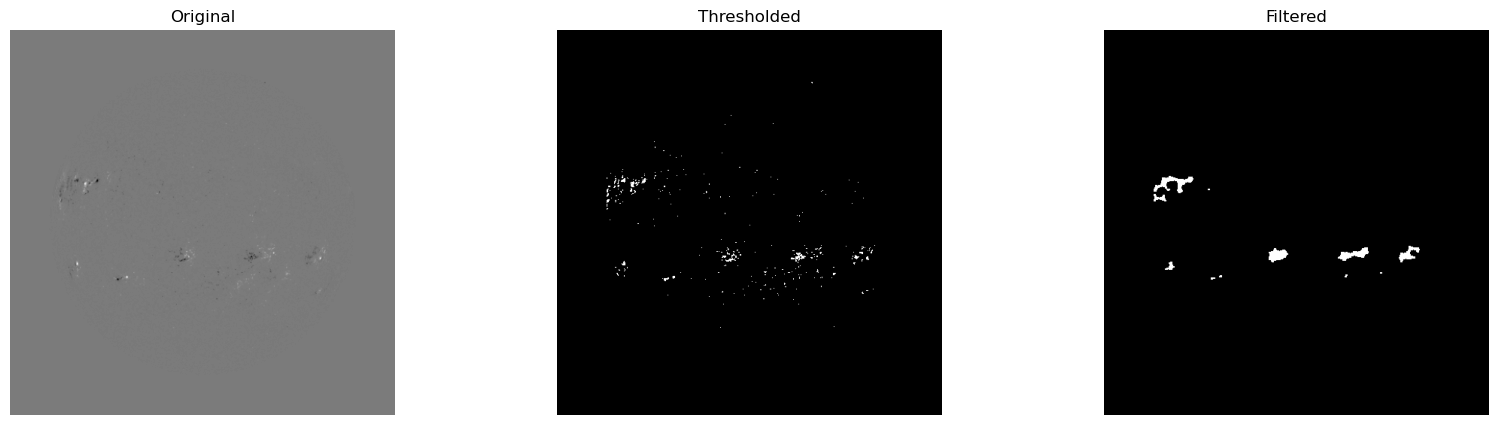

In [7]:
#let's test it out
normal_image = normalize_hmi(images[0])
binary_image = apply_multi_otsu(normal_image)
morphed_image = apply_morph_filter(binary_image)
plt.figure()
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# og image
ax[0].imshow(normal_image, cmap='gray',origin = 'lower')
ax[0].set_title('Original')
ax[0].axis('off')

# thresh binary image
ax[1].imshow(binary_image, cmap='gray',origin = 'lower')
ax[1].set_title('Thresholded')
ax[1].axis('off')

# filtered map
ax[2].imshow(morphed_image, cmap='gray',origin='lower')
ax[2].set_title('Filtered')
ax[2].axis('off')


plt.show()

### We have our segmented regions now, let's extract features


In [8]:
#this is a function that will overlay the border of the segmented region on top of the original image, including its given label
def draw_boundaries(labeled_mask,regions, normalized_image,index,boundary_color):
    
    boundaries = find_boundaries(labeled_mask, mode='inner')
    plt.figure(figsize=(8, 8)) # plot the original grayscale image
    plt.imshow(norm_image, cmap='gray', origin='lower')  
    # overlay the boundaries directly
    plt.contour(boundaries, colors=boundary_color, linewidths=0.8)  # use contour plotting for the mask edges
    #add labels at the centroids of the filtered regions
    for region in regions:
        y, x = region.centroid  # Centroid coordinates
        plt.text(x, y, str(region.label - 1), color="red", fontsize=11, ha='center', va='center')  # Match feature labels

    plt.title(f"Segmented Boundaries with Labels on Image {index}")
    plt.axis('off')
    plt.show()


In [9]:
all_features = []
for i, index in enumerate(indices):
    HMI_image = HMI_data[index]  # Access the image
    norm_image = normalize_hmi(HMI_image)  # Normalize the image
    # Apply segmentation (thresholding + morphological filtering)
    thresholded_image = apply_multi_otsu(norm_image)
    filtered_image = apply_morph_filter(thresholded_image)
    
    # Label connected regions
    labeled_mask, num_features = label(filtered_image, return_num=True)

    # Extract region properties
    regions = regionprops(labeled_mask, intensity_image=norm_image)

    # Filter regions (optional, based on criteria)
    filtered_regions = [
        region for region in regions
        if region.area >= 15 
    ]

    # Extract features for each region
    features = [{
        'Image_Index': indices[i],
        'Date_Time': date_times[i],
        'Label': region.label - 1,  # Matching displayed labels
        'Area': region.area,
        'Perimeter': region.perimeter,
        'Eccentricity': region.eccentricity,
        'Mean Intensity': region.mean_intensity,
        'Max Intensity': region.intensity_image.max(),
        'Min Intensity': region.intensity_image.min(),
        'Intensity Variance': np.var(region.intensity_image),
        'Contrast': graycoprops(
            graycomatrix(
                (region.intensity_image * 255).astype(np.uint8),
                [1], [0]
            ), 'contrast'
        )[0, 0],
        'Homogeneity': graycoprops(
            graycomatrix(
                (region.intensity_image * 255).astype(np.uint8),
                [1], [0]
            ), 'homogeneity'
        )[0, 0],
        'Energy': graycoprops(
            graycomatrix(
                (region.intensity_image * 255).astype(np.uint8),
                [1], [0]
            ), 'energy'
        )[0, 0],
        'Correlation': graycoprops(
            graycomatrix(
                (region.intensity_image * 255).astype(np.uint8),
                [1], [0]
            ), 'correlation'
        )[0, 0]
    } for region in filtered_regions]
    all_features.extend(features)
    #draw_boundaries(labeled_mask,filtered_regions, norm_image, index,"blue") #uncomment this to draw all the boundaries

In [10]:
#now let's make a pandas dataframe for these features
features_df_50 = pd.DataFrame(all_features)
#use zscore normalization for the features
feature_columns = ['Area', 'Perimeter', 'Mean Intensity', 'Eccentricity', 'Contrast', 
                   'Homogeneity', 'Energy', 'Correlation', 'Max Intensity', 'Min Intensity', 'Intensity Variance'] #only the numeric values must get normalized
features_df_zscore = features_df_50.copy()
zscore_scaler = StandardScaler()
features_df_zscore[feature_columns] = zscore_scaler.fit_transform(features_df_50[feature_columns])
features_df_zscore

,Image_Index,Date_Time,Label,Area,Perimeter,Eccentricity,Mean Intensity,Max Intensity,Min Intensity,Intensity Variance,Contrast,Homogeneity,Energy,Correlation
0,16600,2012-06-02T01:34:25.60Z,0,-0.520885,-0.713225,0.674614,-1.790794,-1.062462,-1.573345,2.241525,-1.109408,-1.237916,-0.608953,1.243571
1,16600,2012-06-02T01:34:25.60Z,4,-0.361560,-0.332647,-0.668127,1.003355,1.929024,0.935050,0.197527,1.024558,0.339230,0.367713,-0.245059
2,16600,2012-06-02T01:34:25.60Z,5,0.324107,0.203893,-0.072422,0.159087,0.430561,-1.042084,-0.472665,-0.006516,0.318949,-0.257681,0.688150
3,16600,2012-06-02T01:34:25.60Z,6,0.176162,0.586351,0.483189,0.181096,1.148794,0.724979,-0.753138,-0.355821,1.159064,1.214573,0.916036
4,16600,2012-06-02T01:34:25.60Z,7,0.403769,0.645021,1.155682,0.043865,1.146343,-1.557727,-0.497684,-0.360150,0.997764,1.062847,0.808349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434,18003,2012-06-14T16:10:26.30Z,6,-0.444067,-0.523877,-0.420975,1.464025,0.473266,1.458575,-0.288807,0.091435,-0.079896,-0.173503,-0.444604
435,18039,2012-06-14T23:46:26.40Z,0,0.196078,0.423271,0.983132,-0.159858,0.496720,-0.546260,-0.273120,-0.566165,0.991776,1.258303,0.912171
436,18039,2012-06-14T23:46:26.40Z,1,0.264360,0.708437,1.186393,-0.328346,1.929024,-1.707944,1.334002,-1.074692,1.372066,1.790945,1.188266
437,18039,2012-06-14T23:46:26.40Z,2,-0.170939,-0.185277,-0.404353,-0.237061,0.750882,-0.517901,0.418113,0.509944,-0.965583,-1.276393,-0.135130


### We have our feature space, let's take a look at the correlation between features

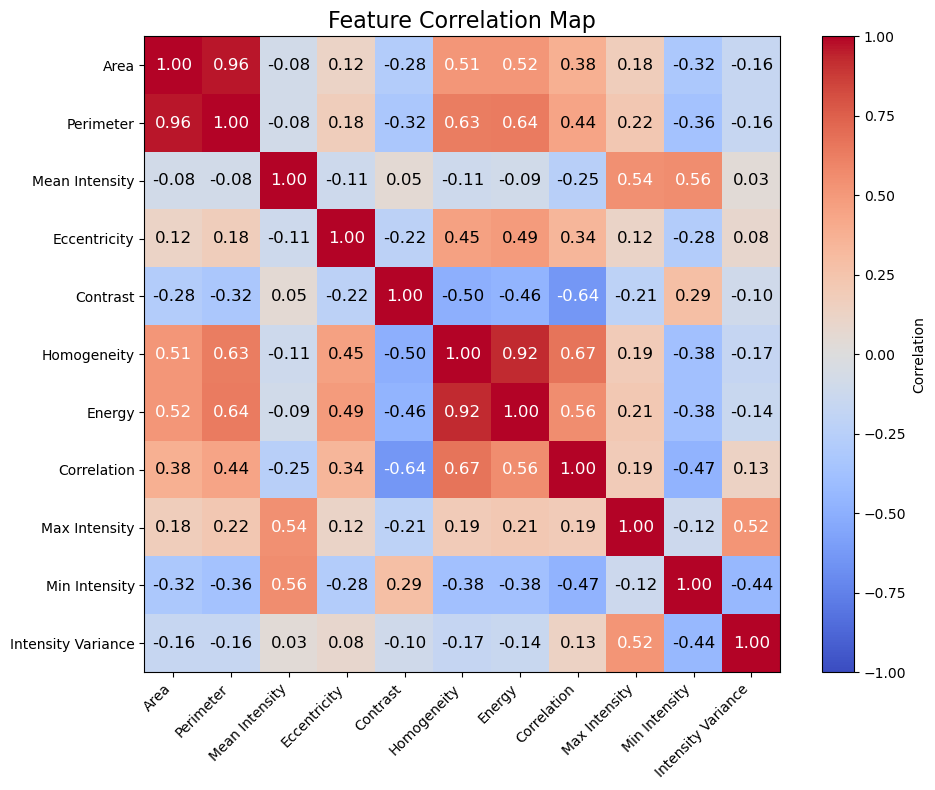

In [11]:

correlation_matrix = features_df_50[feature_columns].corr() #you get the same result for using the normalized dataset
plt.figure(figsize=(10, 8))


plt.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)

# add color bar 
plt.colorbar(label="Correlation")

# set tick positions and labels
plt.xticks(ticks=np.arange(len(feature_columns)), labels=feature_columns, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(feature_columns)), labels=feature_columns)

for i in range(len(feature_columns)): #add the numerical value of the correlation on the map
    for j in range(len(feature_columns)):
        plt.text(j, i, f"{correlation_matrix.iloc[i, j]:.2f}",fontsize = 12,
                 ha="center", va="center", color="black" if abs(correlation_matrix.iloc[i, j]) < 0.5 else "white") #make the text black when the color is blue for readability


plt.title("Feature Correlation Map",fontsize = 16)
plt.tight_layout()
plt.show()

### Now we apply PCA

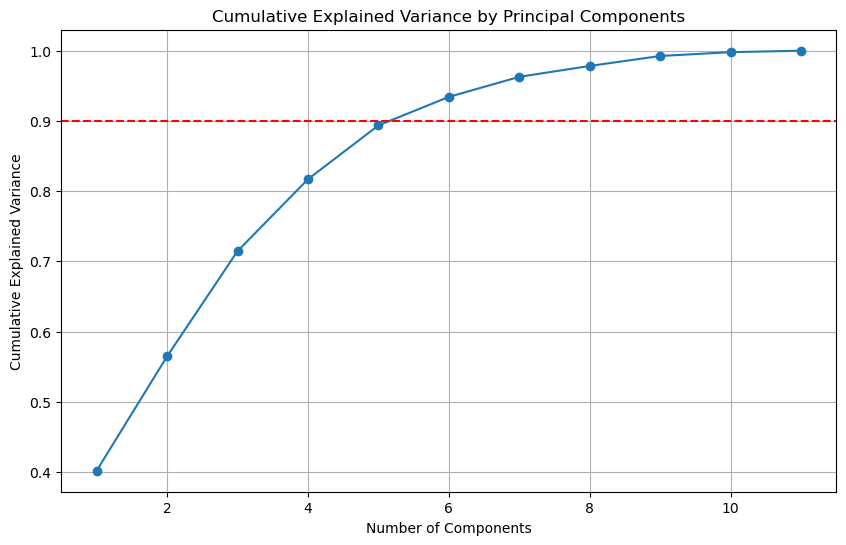

In [12]:
#To decide the optimal number of components, we want the cumulative explained variance around 90 percent
pca = PCA()
# fit PCA to the normalized data
pca.fit(features_df_zscore[feature_columns])
explained_variance = pca.explained_variance_ratio_

#  cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.axhline(y=0.9, color='r', linestyle='--')  # threshold line at 90%
plt.show()

In [13]:
#from the graph we see that in our case, the optimal number is 5
opt_components = 5
pca_5 = PCA(n_components=opt_components)

# apply PCA on normalized features
principal_components_5 = pca_5.fit_transform(features_df_zscore[feature_columns])

# save in dataframe
pca_5_df = pd.DataFrame(data=principal_components_5, columns=[f'PC{i+1}' for i in range(5)])
pca_5_df

,PC1,PC2,PC3,PC4,PC5
0,0.246487,0.426328,-3.835102,-0.203547,-0.763691
1,-0.618505,1.598376,1.411421,0.041716,0.444640
2,0.787596,0.096103,-0.121840,-0.381122,-0.136362
3,1.753060,0.244472,1.240449,0.964244,-0.026068
4,2.504651,0.468971,-0.134722,0.337982,0.737329
...,...,...,...,...,...
434,-1.254643,0.764914,1.613498,0.723351,-0.317066
435,2.137684,0.099099,-0.049225,0.835402,0.271931
436,3.507987,1.939073,-1.016263,0.300258,0.492541
437,-1.082025,0.730059,-0.677978,-1.059377,0.041421


### Apply K-means clustering

C:\Users\wouts\anaconda3\envs\codeBachelorproef\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\wouts\anaconda3\envs\codeBachelorproef\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\wouts\anaconda3\envs\codeBachelorproef\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\wouts\anaconda3\envs\codeBachelorproef\lib\site-packages\s

Optimal number of clusters: 5


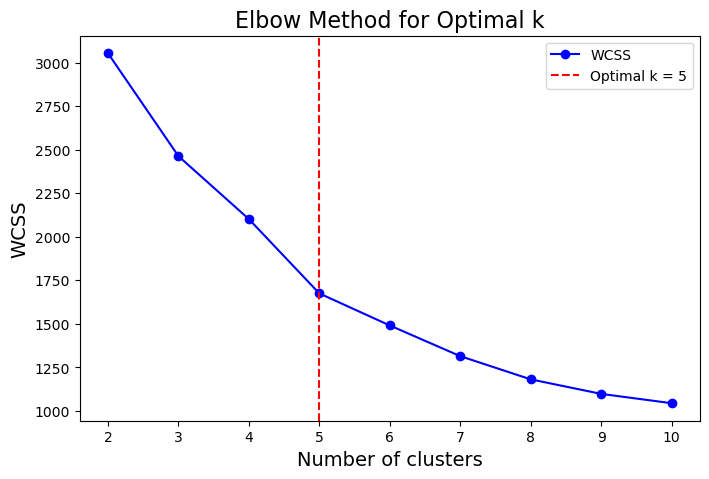

In [14]:
#use kneed package to find knee point
wcss = []  # list to store WCSS/ SSE values
cluster_range = range(2, 11)  # test cluster sizes from 1 to 10

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_5_df)
    wcss.append(kmeans.inertia_) 
kneedle = KneeLocator(cluster_range, wcss, curve="convex", direction="decreasing")
optimal_k = kneedle.knee  # This is the optimal number of clusters
print(f"Optimal number of clusters: {optimal_k}")
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, wcss, 'bo-', label="WCSS")
plt.axvline(x=optimal_k, color='red', linestyle='--', label=f"Optimal k = {optimal_k}")
plt.xlabel("Number of clusters",fontsize = 14)
plt.ylabel("WCSS",fontsize = 14)
plt.title("Elbow Method for Optimal k",fontsize = 16)
plt.legend()
plt.show()

C:\Users\wouts\anaconda3\envs\codeBachelorproef\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


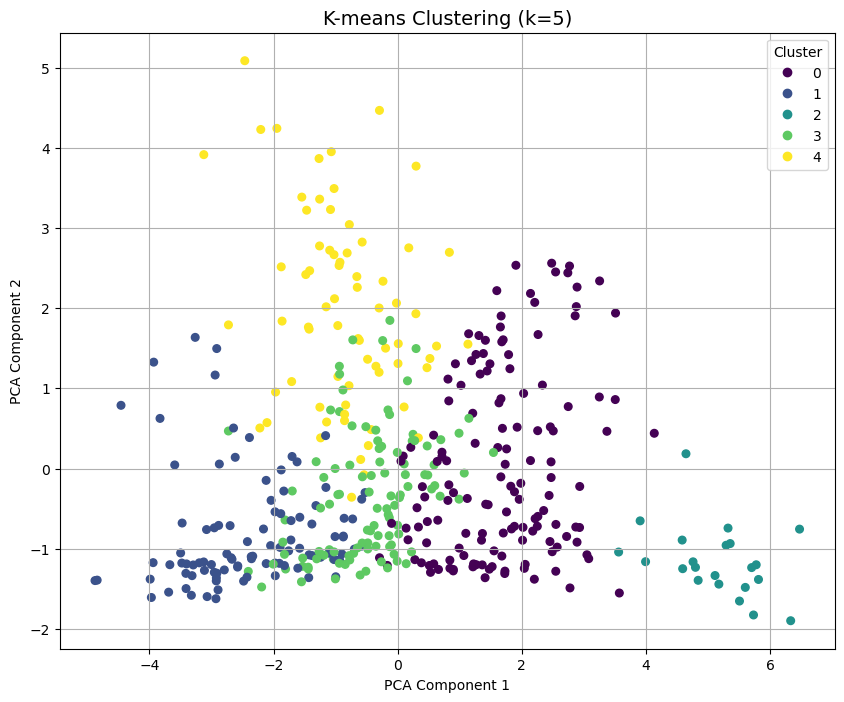

In [27]:
#function to visualize the clustering on the PCA data, just the first two principle components
def visualize_cluster(cluster_amount, dataset):

    fig, axes = plt.subplots(1, 1, figsize=(10, 8))  
    
    kmeans = KMeans(n_clusters=cluster_amount, random_state=42)
    labels = kmeans.fit_predict(dataset)
    
    scatter = axes.scatter(
        dataset.iloc[:, 0], 
        dataset.iloc[:, 1], 
        c=labels, cmap='viridis', s=30
    )
    
    axes.set_title(f'K-means Clustering (k={cluster_amount})', fontsize=14)
    axes.set_xlabel('PCA Component 1')
    axes.set_ylabel('PCA Component 2')
    axes.grid(True)
    
    # Add a color legend for the clusters
    handles, labels_legend = scatter.legend_elements()
    axes.legend(handles, labels_legend, title="Cluster", loc="upper right") 
    plt.show()
visualize_cluster(optimal_k,pca_5_df)

### Next we want to analyze the results, in our case we want to analyze k=4,5,6

In [29]:
#first of all, let's add metadata to the pca dataset so we can find the corresponding features in the original dataset
pca_5_df_with_metadata = pca_5_df.copy()
pca_5_df_with_metadata ['Image_Index'] = features_df_zscore['Image_Index']
pca_5_df_with_metadata ['Label'] = features_df_zscore['Label']
pca_5_df_with_metadata ['Date_Time'] = features_df_zscore['Date_Time'] 

In [56]:
#now we will create 3 copies of the pca dataframe, we will add the cluster labels for k=4,5,6
kmeans_4 = KMeans(n_clusters=4, random_state=42).fit(pca_5_df.iloc[:, :5])
kmeans_5 = KMeans(n_clusters = 5, random_state=42).fit(pca_5_df.iloc[:,:5])
kmeans_6 = KMeans(n_clusters = 6, random_state=42).fit(pca_5_df.iloc[:,:5])
pca_k4 = pca_5_df_with_metadata.copy()
pca_k5 = pca_5_df_with_metadata.copy()
pca_k6 = pca_5_df_with_metadata.copy()
pca_k4['Cluster'] = kmeans_4.labels_  # Add cluster assignment to the dataframe
pca_k5['Cluster'] = kmeans_5.labels_
pca_k6['Cluster'] = kmeans_6.labels_
#also add cluster label to the original dataset, this will come in handy for analyzing feature distributions
features_df_zscore_k4 = features_df_zscore.copy()
features_df_zscore_k4["Cluster"] = pca_k4['Cluster']
features_df_zscore_k5 = features_df_zscore.copy()
features_df_zscore_k5["Cluster"] = pca_k5['Cluster']
features_df_zscore_k6 = features_df_zscore.copy()
features_df_zscore_k6["Cluster"] = pca_k6['Cluster']

C:\Users\wouts\anaconda3\envs\codeBachelorproef\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\wouts\anaconda3\envs\codeBachelorproef\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\wouts\anaconda3\envs\codeBachelorproef\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


C:\Users\wouts\AppData\Local\Temp\ipykernel_16716\3576130289.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', n)


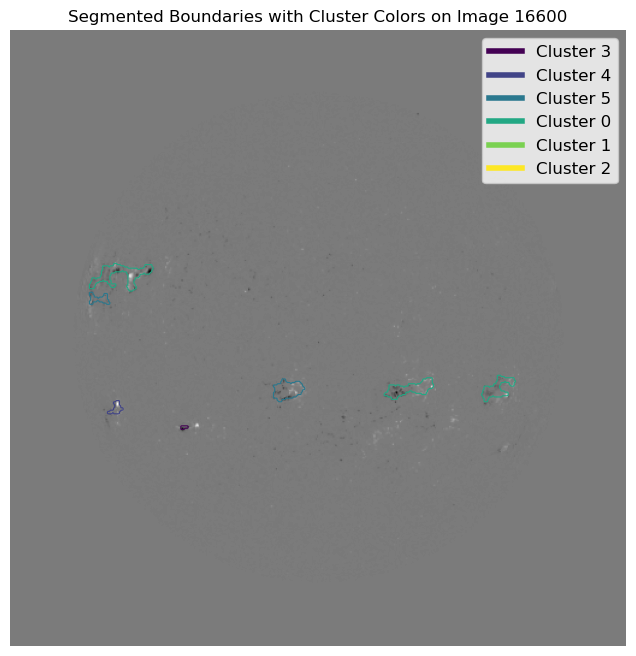

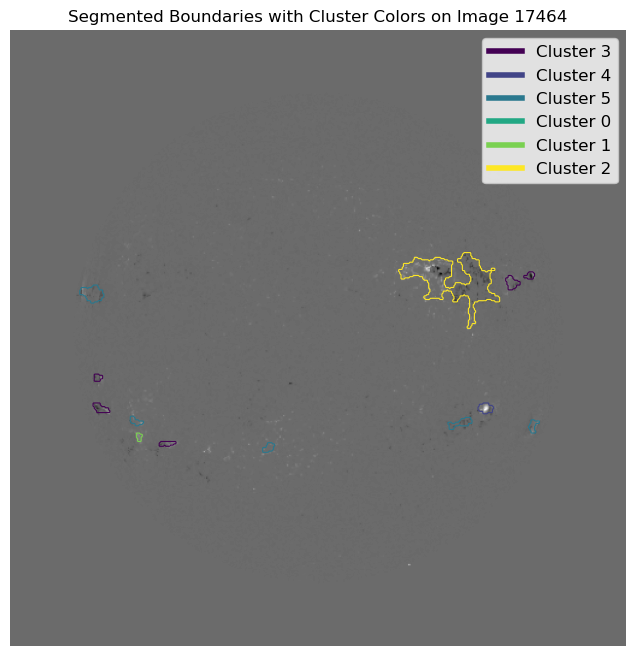

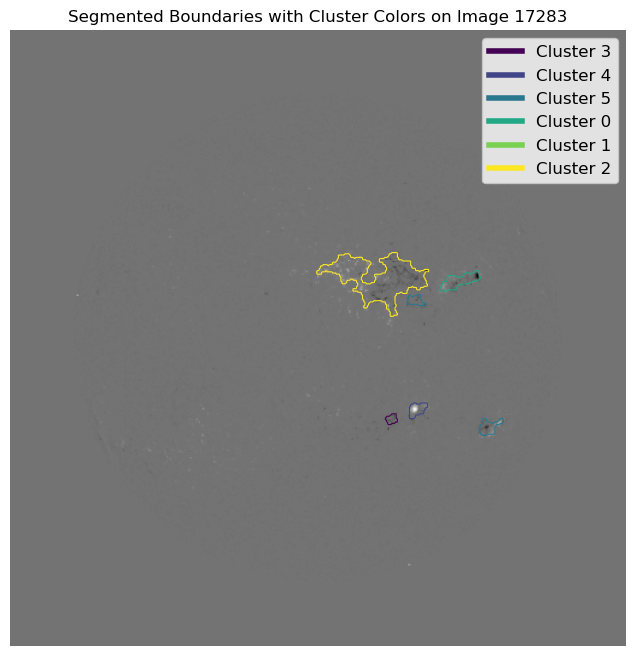

In [55]:

#Let's create a function that takes in a list of samples, and plots the segmented regions color coded according to cluster assignment
indices_samples = [indices[0],indices[30],indices[23]]
def generate_colors(n):
    cmap = cm.get_cmap('viridis', n)  
    return [cmap(i) for i in range(n)]

def draw_boundaries_cluster_assignment(index_list, dataset):
    # assign colors to clusters
    unique_clusters = dataset['Cluster'].unique()
    cluster_to_color = {}
    
    colors = generate_colors(len(unique_clusters))
    for cluster, color in zip(unique_clusters, colors):
        cluster_to_color[cluster] = color
    
    
    for i in index_list:
        # Preprocess the image
        selected_image = HMI_data[i]
        norm_image = normalize_hmi(selected_image)  # Normalize the image
        thresholded_image = apply_multi_otsu(norm_image)  # Apply multi-level Otsu thresholding
        filtered_image = apply_morph_filter(thresholded_image)  # Apply morphological filtering
        labeled_mask, num_features = label(filtered_image, return_num=True)  # Label the regions

        # Access the DataFrame for the current image
        blobs_sample = dataset[dataset["Image_Index"] == i]  # DataFrame containing label-cluster mapping

        # plot the original image
        plt.figure(figsize=(8, 8))
        plt.imshow(norm_image, cmap='gray', origin='lower')  

        # Overlay region boundaries using the DataFrame, could probably be optimized with the draw_boundaries function from the beginning
        for _, row in blobs_sample.iterrows():
            label_number = row["Label"]  # Region label from the DataFrame

            
            adjusted_label = label_number + 1  # Comment this if there's no label mismatch
            cluster = row["Cluster"]  # Cluster assignment from the DataFrame
            color = cluster_to_color.get(cluster, "yellow")  # Default to yellow if no cluster found

            # Overlay the boundary 
            plt.contour(labeled_mask == adjusted_label, colors=[color], linewidths=0.8)

        #legend for clusters
        handles = [Line2D([0], [0], color=color, lw=4) for color in cluster_to_color.values()]
        labels = [f"Cluster {cluster}" for cluster in cluster_to_color.keys()]
        plt.legend(handles, labels, loc='upper right', fontsize=12)

        
        plt.title(f"Segmented Boundaries with Cluster Colors on Image {i}")
        plt.axis('off')
        plt.show()
draw_boundaries_cluster_assignment(indices_samples,pca_k6)

### To analyze the regions in each cluster, we'll look at the histogram/distribution of features in each region

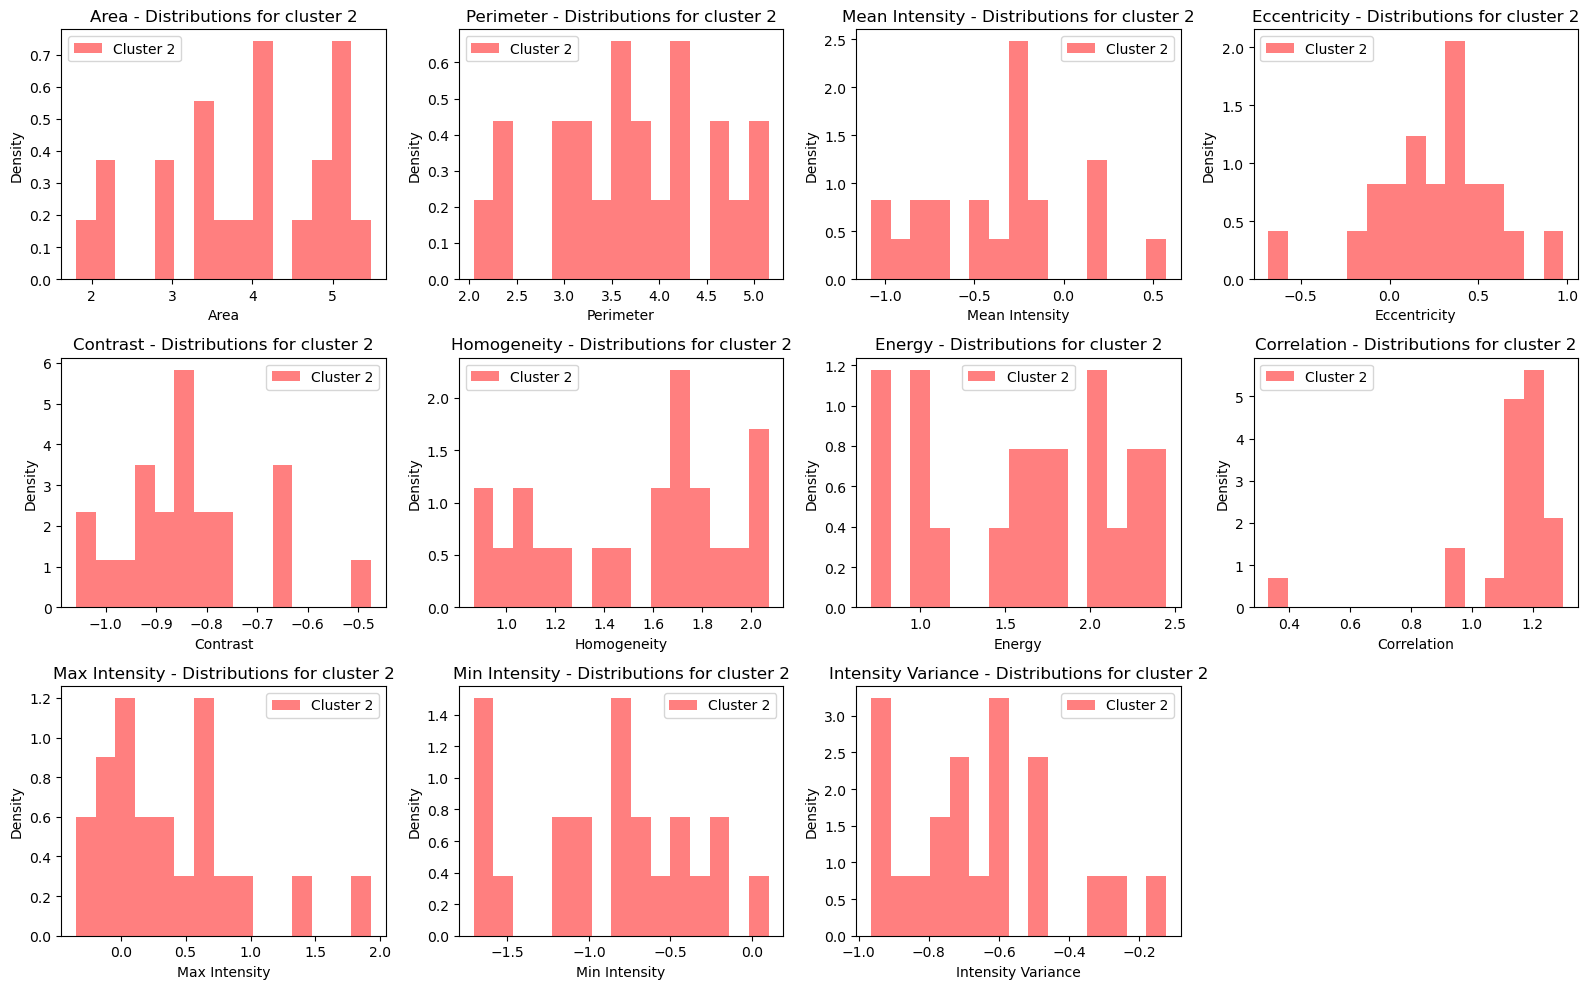

In [59]:

#function to plot the distributions, important: dataset contains original data, not pca data, this is why we added cluster label to the original dataset as well
def plot_distributions(dataset,cluster_label):
    features_only = dataset[feature_columns] #don't include metadata
    num_features = len(feature_columns)
    # grid size 
    num_rows = 3
    num_cols = int(np.ceil(num_features / num_rows)) 
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 10)) 
    axes = axes.flatten()  
    for idx, feature in enumerate(feature_columns):
        
        cluster_values = features_df_zscore[dataset['Cluster'] == cluster_label][feature]
        ax = axes[idx]
        ax.hist(cluster_values, alpha=0.5, bins=15, label=f'Cluster {cluster_label}', color='red', density=True)
        ax.set_title(f"{feature} - Distributions for cluster {cluster_label}")
        ax.set_xlabel(feature)
        ax.set_ylabel("Density")
        ax.legend()

    # Hide unused subplots if num_features is not a multiple of num_rows*num_cols
    for ax in axes[num_features:]:
        ax.axis('off')

    # Adjust layout
    plt.tight_layout()
    plt.show()
plot_distributions(features_df_zscore_k4,2) #distributions cluster 2 k=4